In [1]:

import xarray as xr

store = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/EOBS-feedstock/eobs-tg-tn-tx-rr-hu-pp.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})


In [2]:
target_lat = 62.1
target_lon = 9.25

In [3]:
tg_norway = ds['tg'].sel(
    latitude=target_lat, 
    longitude=target_lon, 
    method='nearest'
).sel(time=slice('2002-01-01', '2020-12-31'))
monthly_mean_full = tg_norway.resample(time='1M').mean()

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [4]:

import xarray as xr

store = 'gs://leap-persistent-ro/data-library/feedstocks/metaflux_feedstock/meatflux_monthly.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})


In [5]:
gpp_2002_2020 = ds.sel(time=slice('2002-01-01', '2020-12-31'))
lat_norway = 62.15
lon_norway = 9.25
norway_gpp = gpp_2002_2020.sel(
    latitude=lat_norway, 
    longitude=lon_norway, 
    method='nearest'
)
norway_reco = gpp_2002_2020.sel(
    latitude=lat_norway, 
    longitude=lon_norway, 
    method='nearest'
)['RECO']

norway_nee = norway_reco - norway_gpp.GPP
monthly_gpp_total = norway_gpp.GPP * norway_gpp.time.dt.days_in_month
monthly_reco_total = norway_reco * norway_reco.time.dt.days_in_month
monthly_nee_total = monthly_reco_total - monthly_gpp_total

In [7]:

import xarray as xr

store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-pipeline/MODIS_LAI/MODIS_LAI.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})


In [8]:
norway_lai = ds.sel(
    lat=lat_norway,
    lon=lon_norway, 
    method='nearest'
)
lai= norway_lai.sel(time=slice('2002-01-01', '2020-12-31'))
monthly_lai = lai['lai'].resample(time='1M').mean()

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [9]:

import xarray as xr

store = 'gs://leap-persistent/data-library/GPCP-daily/GPCP-daily.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})


In [10]:
norway_precip = ds.sel(
    latitude=lat_norway,
    longitude=lon_norway, 
    method='nearest'
)

In [12]:
precip_2002_2020 = norway_precip.sel(time=slice('2002-01-01', '2020-12-31'))
monthly_precip = precip_2002_2020['precip'].resample(time='1M').sum()
daily_precip = precip_2002_2020.precip
daily_precip_loaded = daily_precip.load()
negative_count = (daily_precip_loaded < 0).sum().values
total_count = len(daily_precip_loaded)

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [13]:
clean_daily_precip = daily_precip_loaded.where(daily_precip_loaded >= 0)
monthly_precip_clean = clean_daily_precip.resample(time='1M').sum()


/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [15]:
import pandas as pd

ml_data = pd.DataFrame({
    'time': monthly_precip_clean.time.values,
    'temperature': monthly_mean_full.values,
    'lai': monthly_lai.values,
    'precipitation': monthly_precip_clean.values,
    'nee': monthly_nee_total.values 
})

print(ml_data.head())
print(f"Shape: {ml_data.shape}")

        time  temperature       lai  precipitation        nee
0 2002-01-31    -5.661290  0.111640     106.822304 -12.389620
1 2002-02-28    -6.188571  0.005210     126.971954 -11.071642
2 2002-03-31    -4.732258  0.000000      95.268974 -12.328427
3 2002-04-30     1.192667  0.020144      37.684628 -11.272329
4 2002-05-31     5.573548  0.233350      68.357285 -11.693965
Shape: (228, 5)


In [25]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [17]:
X = ml_data[['temperature', 'lai', 'precipitation']]
y = ml_data['nee']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [27]:
xgb_params = {
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.5,
    'random_state': 42,
    'objective': 'reg:squarederror',
    'eval_metric': ['rmse', 'mae']  
}

In [30]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [33]:
evals_result = {}
final_xgb = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=1000,  
    evals=[(dtrain, 'train'), (dtest, 'test')],  
    early_stopping_rounds=50,  
    evals_result=evals_result,  
    verbose_eval=10  
)

[0]	train-rmse:0.74406	train-mae:0.60006	test-rmse:0.84396	test-mae:0.69456
[10]	train-rmse:0.56082	train-mae:0.43909	test-rmse:0.72127	test-mae:0.59998
[20]	train-rmse:0.44426	train-mae:0.33737	test-rmse:0.64266	test-mae:0.54048
[30]	train-rmse:0.36279	train-mae:0.26862	test-rmse:0.59152	test-mae:0.49863
[40]	train-rmse:0.30642	train-mae:0.22056	test-rmse:0.55251	test-mae:0.46394
[50]	train-rmse:0.26894	train-mae:0.19212	test-rmse:0.53211	test-mae:0.44855
[60]	train-rmse:0.24301	train-mae:0.17539	test-rmse:0.52826	test-mae:0.44576
[70]	train-rmse:0.22315	train-mae:0.16197	test-rmse:0.52308	test-mae:0.44128
[80]	train-rmse:0.20444	train-mae:0.14894	test-rmse:0.51381	test-mae:0.43531
[90]	train-rmse:0.18938	train-mae:0.13897	test-rmse:0.50550	test-mae:0.42988
[100]	train-rmse:0.17754	train-mae:0.13120	test-rmse:0.49854	test-mae:0.42582
[110]	train-rmse:0.16876	train-mae:0.12588	test-rmse:0.49768	test-mae:0.42599
[120]	train-rmse:0.16006	train-mae:0.11986	test-rmse:0.49670	test-mae:0.424

In [35]:
print(f"Best iteration: {final_xgb.best_iteration}")

Best iteration: 484


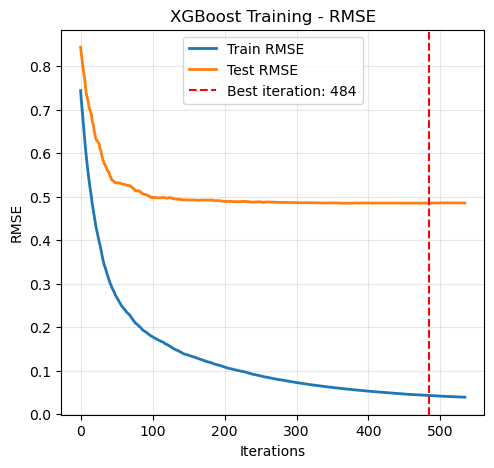

In [39]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_rmse = evals_result['train']['rmse']
test_rmse = evals_result['test']['rmse']

epochs = len(train_rmse)
x_axis = range(0, epochs)

plt.plot(x_axis, train_rmse, label='Train RMSE', linewidth=2)
plt.plot(x_axis, test_rmse, label='Test RMSE', linewidth=2)
plt.axvline(x=final_xgb.best_iteration, color='red', linestyle='--', 
            label=f'Best iteration: {final_xgb.best_iteration}')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('XGBoost Training - RMSE')
plt.legend()
plt.grid(True, alpha=0.3)


temperature: 0.2403
lai: 0.3904
precipitation: 0.3693


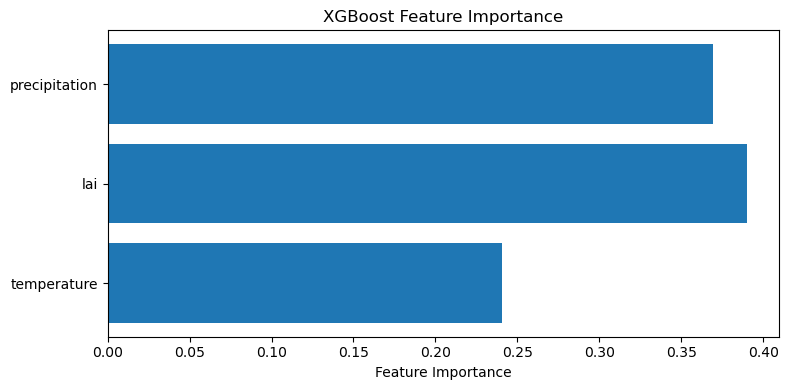

In [53]:
from xgboost import XGBRegressor

xgb_sklearn = XGBRegressor(
    n_estimators=484,  
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.5,
    random_state=42,
    objective='reg:squarederror'
)

xgb_sklearn.fit(X_train, y_train)

xgb_importance = xgb_sklearn.feature_importances_
features = X.columns

for feature, importance in zip(features, xgb_importance):
    print(f"{feature}: {importance:.4f}")

plt.figure(figsize=(8, 4))
plt.barh(features, xgb_importance)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()


In [55]:
y_pred_xgb_sklearn = xgb_sklearn.predict(X_test)

mse_xgb_sklearn = mean_squared_error(y_test, y_pred_xgb_sklearn)
rmse_xgb_sklearn = np.sqrt(mse_xgb_sklearn)
mae_xgb_sklearn = mean_absolute_error(y_test, y_pred_xgb_sklearn)
r2_xgb_sklearn = r2_score(y_test, y_pred_xgb_sklearn)

print(f"MSE: {mse_xgb_sklearn:.4f}")
print(f"RMSE: {rmse_xgb_sklearn:.4f}")
print(f"MAE: {mae_xgb_sklearn:.4f}")
print(f"R²: {r2_xgb_sklearn:.4f}")

MSE: 0.2356
RMSE: 0.4854
MAE: 0.4118
R²: 0.6771
